In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision
import scipy as scp
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# Meitner Machine
import ae
import conv_ae
import ewm
import utils
from dataloader import LArCV_loader

#### Set the GPU to be used for model evaluation
- On Meitner, GPU 1 is the best option

In [3]:
device = torch.device(1)

#### Set the root path of the AutoEncoder Experiments Folder

In [4]:
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

#### Select the model class and append to the experiment root

In [5]:
mlp = False
if mlp:
    AE_root = exp_root + 'larcv_ae/mlp_ae/'
    EWM_root = exp_root + 'ewm_models/mlp_ewm/'
else:
    AE_root = exp_root + 'larcv_ae/conv_ae/'
    EWM_root = exp_root + 'ewm_models/conv_ewm/'

In [6]:
# Path to model weights
weights_dir = "weights/"

# Select the AutoEncoder and Generator Models you want to deploy

## Get the names of all the saved AutoEncoder experiments in the exp_root folder

In [7]:
AE_paths = []
for path in os.listdir(AE_root):
    AE_paths.append(os.path.join(AE_root, path))

print("-"*60)
for i in range(len(AE_paths)):
    AE_name = AE_paths[i].split('/')[-1]
    print("\n Exp_{}:".format(str(i)), AE_name, '\n')
    print("-"*60)

------------------------------------------------------------

 Exp_0: conv_ae_256_102-8-8_6528 

------------------------------------------------------------

 Exp_1: conv_ae_64_6-8-8_384 

------------------------------------------------------------

 Exp_2: phase_1_models 

------------------------------------------------------------

 Exp_3: conv_ae_128_40-8-8_2560 

------------------------------------------------------------


## Select the AutoEncoder experiment you want

In [8]:
AE_dir = AE_paths[1]

In [9]:
# Create the full path to the AutoEncoder experiment
AE_path = os.path.join(AE_root, AE_dir) + "/"
print("Path to AutoEncoder set as: \n{}".format(AE_path))

Path to AutoEncoder set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_6-8-8_384/


## Get the names of all the saved EWM Generator models

In [10]:
EWM_paths = []
# EWM_root += 'evaluated_models/'
for path in os.listdir(EWM_root):
    EWM_paths.append(os.path.join(EWM_root, path))

print("-"*60)
for i in range(len(EWM_paths)):
    EWM_name = EWM_paths[i].split('/')[-1]
    print("\n Exp_{}:".format(str(i)), EWM_name, '\n')
    print("-"*60)

------------------------------------------------------------

 Exp_0: ewm_tess_0-5_100-epochs_64_384 

------------------------------------------------------------

 Exp_1: ewm_tess_1-0_100-epochs_64_384 

------------------------------------------------------------

 Exp_2: ewm_tess_0-25_10-epochs_64_384 

------------------------------------------------------------

 Exp_3: ewm_tess_0-75_10-epochs_64_384 

------------------------------------------------------------

 Exp_4: evaluated_models 

------------------------------------------------------------

 Exp_5: ewm_tess_0-50_10-epochs_64_384 

------------------------------------------------------------


## Select the EWM model experiment you want

In [11]:
EWM_dir = EWM_paths[1]

In [12]:
# Create the full path to the EWM model
EWM_path = os.path.join(EWM_root, EWM_dir) + "/"
print("Path to EWM Generator Model set as: \n{}".format(EWM_path))

Path to EWM Generator Model set as: 
/media/hdd1/kai/particle_generator/experiments/ewm_models/conv_ewm/ewm_tess_1-0_100-epochs_64_384/


# Load selected models from checkpoint and onto GPU

## Load the AE config .csv as a dict
- Get the model architecture from the config_df

In [13]:
config_csv = AE_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [14]:
# Get the model architecture from config df
num_epochs = int(config_df[config_df['Unnamed: 0'].str.contains("epochs")==True]['0'].values.item())
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
im_dim   = int(np.sqrt(im_size))

## Set up AutoEncoder model on the GPU

### Compute the layer dimensions for the AutoEncoder
- TODO: Need to add function that deals with an AutoEncoder Model trained on MNIST

In [15]:
# Set up AE layer sizes
if 'mlp' in AE_root:    
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    # Compute the depth of the feature maps, based on the number of
    # specified layers. If depth is not divisibe by 4, warn
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
        
    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_depth':[1] + depth, 'dec_depth':depth[1:len(depth)][::-1] + [1],'l_dim':l_dim}

In [16]:
print("Model l_dim: {}".format(l_dim))
print("Encoder depth: {}".format(ae_kwargs['enc_depth']))
print("Decoder depth: {}".format(ae_kwargs['dec_depth']))

Model l_dim: 6
Encoder depth: [1, 8, 16, 32]
Decoder depth: [32, 16, 1]


In [17]:
# Set up model on GPU
if 'mlp' in AE_root:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

## Load the AE model checkpoint

In [18]:
# Get checkpoint name(s)
AE_checkpoint_path  = AE_path + weights_dir
AE_checkpoint_names = []
for file in os.listdir(AE_checkpoint_path):
    AE_checkpoint_names.append(os.path.join(AE_checkpoint_path, file))

In [19]:
print("-"*60)
for i in range(len(AE_checkpoint_names)):
    name = AE_checkpoint_names[i].split('/')[-1]
    AE_checkpoint_names.append(name)
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


In [20]:
# Select the desired checkpoint from the list
AE_checkpoint = AE_checkpoint_names[2]

In [21]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(AE_checkpoint)

In [22]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
# Put the model in evaluation mode
model.eval()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (last): Conv2d(32, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): ConvDecoder(
    (deconv_blocks): Sequential(
      (0): Sequential(
        (0): Upsample(scale_factor=2.

### If evaluating convolutional model, get the size of the code tensor using a random torch tensor

In [24]:
if 'conv' in AE_root:
    x = torch.randn(1, 1, im_dim, im_dim).to(device)
    x = model.encoder(x)
    code = (x.shape[1], x.shape[2], x.shape[3])
    print("Code tensor volume is: [{} x {} x {}] = {}".format(code[0], code[1], code[2], code[0]*code[1]*code[2]))

Code tensor volume is: [6 x 8 x 8] = 384


In [25]:
x.shape

torch.Size([1, 6, 8, 8])

## Load the G config .csv as a dict
- Get the model architecture from the config_df

In [26]:
config_csv = EWM_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [27]:
# Get the model architecture from config df
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
n_hidden = int(config_df[config_df['Unnamed: 0'].str.contains("n_hidden")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())
z_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("z_dim")==True]['0'].values.item())
print("{} Layer model with {} hidden units per layer".format(n_layers, n_hidden))
if 'mlp' in EWM_root:
    print("Mapping {}_dim_Gaussian to {}_dim code vectors".format(z_dim, l_dim))
else:
    print("Mapping {}_dim_Gaussian to {}_dim code vectors".format(z_dim, code[0]*code[1]*code[2]))

4 Layer model with 512 hidden units per layer
Mapping 100_dim_Gaussian to 384_dim code vectors


## Set up the Generator model

In [28]:
# Model kwargs
fc_sizes = [n_hidden] * n_layers
ewm_kwargs = { 'z_dim': z_dim, 'fc_sizes': fc_sizes, 'n_out': code[0]*code[1]*code[2]}
# fc_sizes = [512] * 4
# ewm_kwargs = { 'z_dim': 100, 'fc_sizes': fc_sizes, 'n_out': 384}

In [29]:
# Create generator on GPU
G = ewm.ewm_G(**ewm_kwargs).to(device)

## Load EWM model checkpoint

In [30]:
# Get checkpoint name(s)
EWM_checkpoint_path  = EWM_path + weights_dir
EWM_checkpoint_names = []
for file in os.listdir(EWM_checkpoint_path):
    EWM_checkpoint_names.append(os.path.join(EWM_checkpoint_path, file))

In [31]:
print("-"*60)
for i in range(len(EWM_checkpoint_names)):
    name = EWM_checkpoint_names[i].split('/')[-1]
    print("\n {} :".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

 0 : best_ewm_ep_99.tar 

------------------------------------------------------------

 1 : best_ewm_ep_1.tar 

------------------------------------------------------------


In [48]:
# Select the checkpoint you want
EWM_checkpoint = EWM_checkpoint_names[0]

In [49]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
# checkpoint = torch.load(EWM_checkpoint)
checkpoint = torch.load(EWM_checkpoint)

In [50]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
G.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [51]:
# Put the model in evaluation mode
G.eval()

ewm_G(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.5)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.5)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.5)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.5)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=512, out_features=384, bias=True)
  )
)

## Check that the l_dim of the AE is the same as the out_dim of the Generator

In [52]:
if 'mlp' in AE_root:
    ae_l_dim = AE.encoder.last.out_features
else:
    ae_l_dim = code[0]*code[1]*code[2]
g_out_dim = G.out[0].out_features

In [53]:
if ae_l_dim != g_out_dim:
    print("Code vector sizes do not match!")
    print("AE: {} | G: {}".format(ae_l_dim, g_out_dim))
else:
    print("Code vector sizes match")

Code vector sizes match


#### Compute the arguments for reshaping the Generator's output

In [54]:
model.decoder.deconv_blocks[0][2].in_channels
model.decoder.deconv_blocks[0][2].out_channels

32

In [55]:
in_f  = model.decoder.deconv_blocks[0][2].in_channels
out_f = model.decoder.deconv_blocks[0][2].out_channels
h = code[1]
w = code[2]
print('[{},{},{},{}]'.format(in_f, out_f, h, w))

[6,32,8,8]


## Deploy the Decoder using G as an input

In [56]:
z_dim = 100
mean = []; var = []
for i in range(1000):
    out = G(torch.randn(1, 1, z_dim).to(device))
    out = out.detach().cpu().numpy()
    mean.append(np.mean(out))
    var.append(np.var(out))

In [57]:
print(np.mean(mean), np.mean(var))

-1.2888472 78.15536


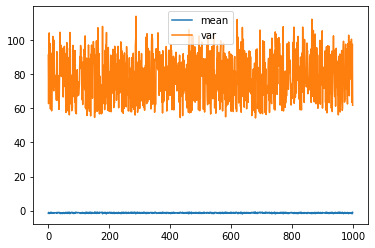

In [58]:
%matplotlib inline
plt.plot(mean, label='mean')
plt.plot(var, label='var')
plt.legend()

In [64]:
samples1 = []; samples2 = []; limit = 16

In [65]:
for itr in range(limit):
    # Create an input vector for G
    z_rand = torch.randn(2, 1, z_dim).to(device)
    
    # Get a code vector from G
    code_vec = G(z_rand).view(2, in_f, h, w).to(device) + torch.randn(2, in_f, h, w).to(device)*2
    
    # Push code_vec through Decoder
    sample = model.decoder(code_vec)
    
    # Reshape the sample, detach, and convert to numpy array
    samples1.append(sample[0].view(im_dim, im_dim).detach().cpu().numpy())
    samples2.append(sample[1].view(im_dim, im_dim).detach().cpu().numpy())

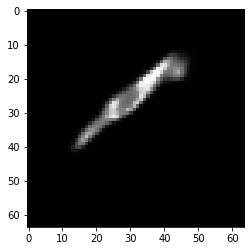

In [66]:
%matplotlib inline
plt.imshow(samples1[0], cmap='gray')

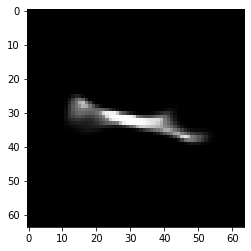

In [67]:
plt.imshow(samples1[6], cmap='gray')

## Viz the deploy samples

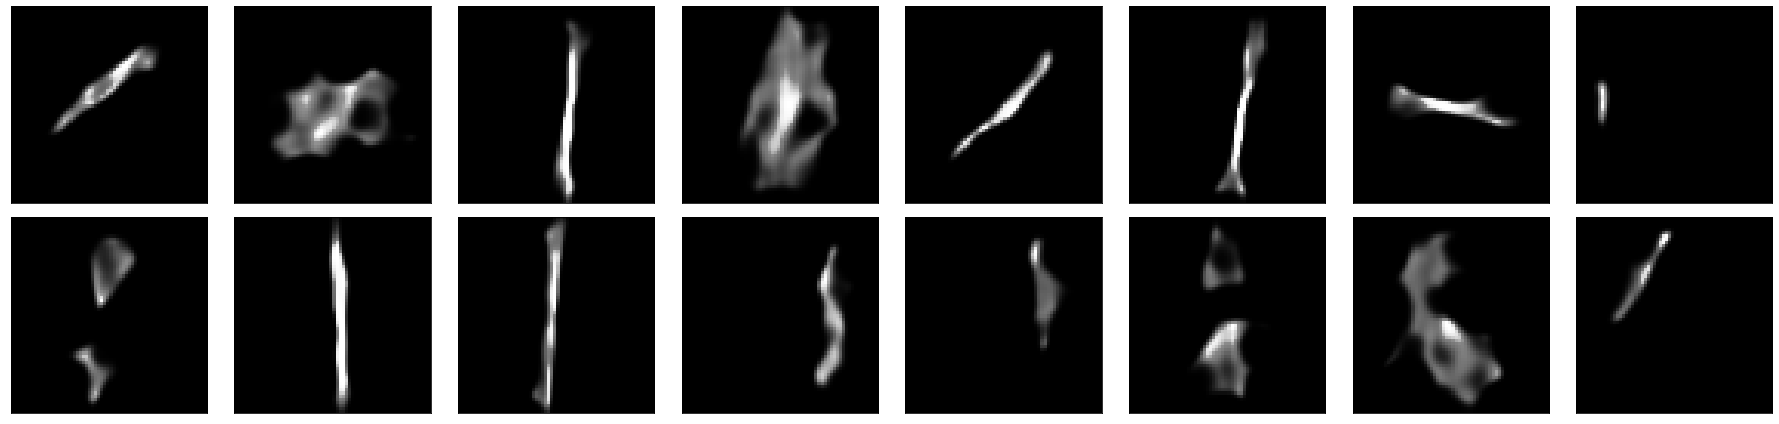

In [68]:
%matplotlib inline
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = 8, sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in AE_root:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

# Generate plot
for images, row in zip([samples1, samples2], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')
fig.tight_layout()

# Save figure
save_file = "ewm_ae_{}_{}_{}.png".format(im_dim, code[0]*code[1]*code[2], m_label)
plt.savefig(save_file, dpi=300)